# 1. Download dipendenze

In [38]:
# !pip install torchtext==0.17.0
# !pip install spacy

# # installing spacy italian language
# !python -m spacy download it_core_news_sm

# 2. Import

In [39]:
import torch
import torch.nn as nn
import pandas as pd
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torch.utils.data import Dataset
from torch import Tensor
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np



# 3. Custom Dataset

In [40]:
class CustomDataset(Dataset):

    def __init__(self, file_path: str):
        self.file_path = file_path
        self.data = pd.read_csv(file_path)
        self.inputs = self.data["Input"].to_list()
        self.outputs = self.data.apply(lambda row: f'asset: {row["Asset"]}, start: {row["Start"]}, end: {row["End"]}', axis=1).tolist()

        self.tokenizer = get_tokenizer(tokenizer="spacy", language="it_core_news_sm")
        self.vocab_specials = ["<unk>", "<pad>", "<sos>", "<eos>"]
        self.source_vocab = self.__build_vocab__(self.inputs)
        self.target_vocab = self.__build_vocab__(self.outputs)

        self.source_vocab.set_default_index(self.source_vocab["<unk>"])
        self.target_vocab.set_default_index(self.target_vocab["<unk>"])


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # 1. Recupero input e relativo output atteso
        source = self.inputs[index]
        target = self.outputs[index]

        # 2. Trasformazione del testo di input
        transformed_input = self.__transform__(source, self.source_vocab)

        # 3. Trasformazione dell'output
        transformed_output = self.__transform__(target, self.target_vocab)

        return {
            "input_ids": transformed_input,
            "labels": transformed_output
        }

    def __yield_tokens__(self, sentences):
        for text in sentences:
            yield self.tokenizer(text)

    def __build_vocab__(self, sentences):
        return build_vocab_from_iterator(
            iterator=self.__yield_tokens__(sentences),
            specials=self.vocab_specials,
            special_first=True
        )

    def __transform__(self, sentence, vocab) -> Tensor:
        tokens = self.tokenizer(sentence)
        transform_pipeline = T.Sequential(
            # Converte le parole nei rispettivi indici del vocabolario
            T.VocabTransform(vocab),

            # Aggiunge <sos> all'inizio della frase.
            # 2 è l'indice che ha il token nel vocabolario (vedi vocab_specials)
            T.AddToken(token=2, begin=True),

            T.Truncate(max_seq_len=256),

            # Aggiunge <eos> alla fine della frase.
            # 3 è l'indice che ha il token nel vocabolario (vedi vocab_specials)
            T.AddToken(3, begin=False),

            # Trasforma in un tensore
            T.ToTensor(padding_value=1),

            T.PadTransform(max_length=256, pad_value=1))
        return transform_pipeline(tokens)

    def info(self):
        print("---------------------------------")
        print("Dataset Info")
        print("---------------------------------")
        print(f"Data location:\t\"{self.file_path}\"")
        print(f"Data length:\t{len(self.data)} records")
        print(f"Source vocab length:\t{len(self.source_vocab)} words")
        print(f"Target vocab length:\t{len(self.target_vocab)} words")
        print("---------------------------------")
        print("END Info")
        print("---------------------------------")

if __name__ == "__main__":
    cd = CustomDataset(file_path="datasets/train/train.csv")
    cd.info()

    for i, cd in enumerate(cd):
        if i > 5: break
        print(f"Campione {i}: {cd}")


/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


---------------------------------
Dataset Info
---------------------------------
Data location:	"datasets/train/train.csv"
Data length:	1000 records
Source vocab length:	208 words
Target vocab length:	1253 words
---------------------------------
END Info
---------------------------------
Campione 0: {'input_ids': tensor([ 2,  5, 14, 19,  9, 84,  8,  4, 91,  7, 33, 13, 12, 17, 11,  3,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  

# 4. Model

In [41]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()

        self.dropout = nn.Dropout(p)
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(
            embedding_size, hidden_size, num_layers, dropout=p, batch_first=True
        )

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell


In [42]:
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, num_layers, p):
        super(Decoder, self).__init__()

        self.dropout = nn.Dropout(p)
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(0)
        embedded = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        predictions = self.fc(outputs)

        predictions = predictions.squeeze(0)
        return predictions, hidden, cell


In [43]:
class SpaceAIModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(SpaceAIModel, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        target_len = target.shape[1]
        batch_size = target.shape[0]
        target_vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
        hidden, cell = self.encoder(source)
        input = target[:, 0]

        for t in range(1, target_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            best_guess = output.argmax(1)
            input = (
                target[:, t]
                if torch.rand(1).item() < teacher_forcing_ratio
                else best_guess
            )

        return outputs


# 5. Metrics

In [44]:
class Metrics:
    def __init__(self, real: np.array, prediction: np.array):
        self.real = real
        self.prediction = prediction

    def token_level_accuracy(self):
        correct = 0
        total = 0
        for pred, real in zip(self.prediction, self.real):
            correct += sum(
                pred_token == real_token for pred_token, real_token in zip(pred, real)
            )
            total += len(real)

        return correct / total


# 6. Runner

In [45]:
class SpaceAIRunner:
    def __init__(
        self,
        batch_size,
        epochs,
        source_vocab,
        target_vocab,
        embedding_size,
        hidden_size,
        num_layers,
        dropout,
        lr,
    ):
        self.batch_size = batch_size
        self.epochs = epochs

        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        encoder = Encoder(
            len(source_vocab), embedding_size, hidden_size, num_layers, dropout
        ).to(self.device)
        decoder = Decoder(
            len(target_vocab), embedding_size, hidden_size, num_layers, dropout
        ).to(self.device)

        self.net = SpaceAIModel(encoder, decoder, self.device).to(self.device)

        self.loss = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)

    def train(
        self,
        train_loader: torch.utils.data.DataLoader,
        validation_loader: torch.utils.data.DataLoader,
        out_root: str,
    ):
        out_root = Path(out_root)
        if not out_root.exists():
            out_root.mkdir()

        step_counter = 0
        step_monitor = 5
        ep_monitor = 2
        losses_x, losses_y = [], []
        run_losses_x, run_losses_y = [], []

        for epoch in range(self.epochs):
            self.net.train()

            running_loss = 0.0

            print(f"Epoch {epoch + 1} / {self.epochs}")
            for i, data in enumerate(train_loader):
                source, target = data["input_ids"].to(self.device), data["labels"].to(
                    self.device
                )
                outputs = self.net(source, target)

                outputs = outputs[1:].reshape(-1, outputs.shape[2])
                target = target.T[1:].reshape(-1)

                loss = self.loss(outputs, target)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                if (i + 1) % step_monitor == 0:
                    run_losses_y.append(running_loss / step_monitor)
                    run_losses_x.append(step_counter)
                    print(
                        f"GlobalStep: {(step_counter + 1):5d} - [Epoca: {epoch + 1:3d}, Step: {i + 1:5d}] loss: {loss.item():.6f} - running_loss: {(running_loss / step_monitor):.6f}"
                    )
                    running_loss = 0.0

                losses_x.append(step_counter)
                losses_y.append(loss.item())
                step_counter += 1

            if (epoch + 1) % ep_monitor == 0:
                print(f"\n *** *** VALIDATION *** ***")
                t_accuracy = self.test(validation_loader, use_current_net=True)
                print(
                    f"GlobalStep: {step_counter:5d} - [Epoca: {epoch + 1:3d}, token_level_accuracy: {t_accuracy:.2f}"
                )

        print("Finished training!")

        torch.save(self.net.state_dict(), out_root / "model_sd.pth")
        torch.save(self.net, out_root / "model.pth")
        print("Model saved!")

        plt.plot(losses_x, losses_y)
        plt.plot(run_losses_x, run_losses_y)
        plt.show()

    def test(self, test_loader: torch.utils.data.DataLoader, use_current_net=False):
        net = self.net
        if use_current_net == False:
            try:
                net.load_state_dict(torch.load("out/model_sd.pth"))
            except:
                print("Model not found.")
                return

        net.eval()

        total_target = []
        total_prediction = []

        with torch.no_grad():
            for i, data in enumerate(test_loader):
                source, target = data["input_ids"].to(self.device), data["labels"].to(
                    self.device
                )
                outputs = net(source, target, teacher_forcing_ratio=0)
                output_tokens = outputs.argmax(2).T

                for i in range(len(source)):
                    input_sentence = " ".join(
                        self.source_vocab.lookup_tokens(source[i].tolist())
                    )
                    target_json = self.target_vocab.lookup_tokens(target[i].tolist())
                    predicted_json = self.target_vocab.lookup_tokens(
                        output_tokens[i].tolist()
                    )

                    total_target.append(target_json)
                    total_prediction.append(predicted_json)

        metrics = Metrics(total_target, total_prediction)
        token_level_accuracy = metrics.token_level_accuracy()
        return token_level_accuracy


# 7. Main

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Epoch 1 / 5
GlobalStep:     5 - [Epoca:   1, Step:     5] loss: 3.497605 - running_loss: 5.687072
GlobalStep:    10 - [Epoca:   1, Step:    10] loss: 0.632149 - running_loss: 1.121101
GlobalStep:    15 - [Epoca:   1, Step:    15] loss: 0.444084 - running_loss: 0.555837
GlobalStep:    20 - [Epoca:   1, Step:    20] loss: 0.361927 - running_loss: 0.383238
GlobalStep:    25 - [Epoca:   1, Step:    25] loss: 0.311705 - running_loss: 0.329694
GlobalStep:    30 - [Epoca:   1, Step:    30] loss: 0.294427 - running_loss: 0.299561
GlobalStep:    35 - [Epoca:   1, Step:    35] loss: 0.273248 - running_loss: 0.281179
GlobalStep:    40 - [Epoca:   1, Step:    40] loss: 0.265604 - running_loss: 0.269052
GlobalStep:    45 - [Epoca:   1, Step:    45] loss: 0.258284 - running_loss: 0.260074
GlobalStep:    50 - [Epoca:   1, Step:    50] loss: 0.252560 - running_loss: 0.254086
Epoch 2 / 5
GlobalStep:    55 - [Epoca:   2, Step:     5] loss: 0.244221 - running_loss: 0.247241
GlobalStep:    60 - [Epoca:   

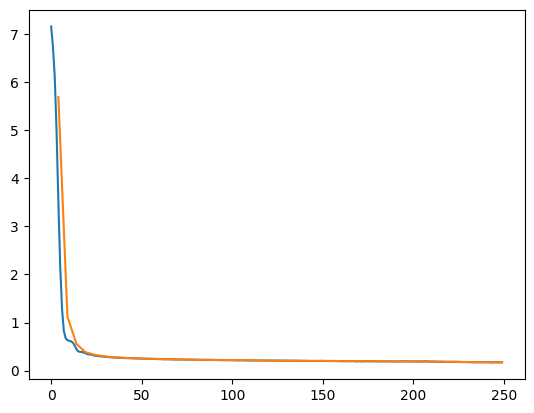

In [46]:
BATCH_SIZE = 20
EPOCHS = 5
SHUFFLE = False
EMB_DIM = 150
HID_DIM = 300
N_LAYERS = 2
DROPOUT = 0.5
TRAIN = True
LR = 0.001


tr_dataset = CustomDataset(file_path="datasets/train/train.csv")
te_dataset = CustomDataset(file_path="datasets/test/test.csv")
va_dataset = CustomDataset(file_path="datasets/validation/validation.csv")

tr_loader = torch.utils.data.DataLoader(
    tr_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE
)
te_loader = torch.utils.data.DataLoader(
    te_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE
)
va_loader = torch.utils.data.DataLoader(
    va_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE
)

runner = SpaceAIRunner(
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    source_vocab=tr_dataset.source_vocab,
    target_vocab=tr_dataset.target_vocab,
    embedding_size=EMB_DIM,
    hidden_size=HID_DIM,
    num_layers=N_LAYERS,
    dropout=DROPOUT,
    lr=LR,
)

if TRAIN:
    runner.train(train_loader=tr_loader, validation_loader=va_loader, out_root="out")
else:
    print(f"\n *** *** TESTING *** ***")
    t_accuracy, s_accuracy = runner.test(test_loader=te_loader)
    print("Finished testing!")
    print(f"token_level_accuracy: {t_accuracy:.2f}")
